In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

Precompiling SciMLSensitivity
  ✓ LogExpFunctions → LogExpFunctionsInverseFunctionsExt
  ✓ CPUSummary
  ✓ PolyesterWeave
  ✓ StatsFuns → StatsFunsInverseFunctionsExt
  ✓ Polyester
  ✓ FastBroadcast
  ✓ SparseDiffTools → SparseDiffToolsPolyesterExt
  ✓ VectorizationBase
  ✓ SLEEFPirates
  ✓ Unitful
  ✓ Unitful → InverseFunctionsUnitfulExt
  ✓ Accessors → AccessorsUnitfulExt
  ✓ LoopVectorization
  ✓ LoopVectorization → SpecialFunctionsExt
  ✓ RecursiveArrayTools → RecursiveArrayToolsReverseDiffExt
  ✓ LoopVectorization → ForwardDiffExt
  ✓ RecursiveArrayTools → RecursiveArrayToolsFastBroadcastExt
  ✓ TriangularSolve
  ✓ RecursiveArrayTools → RecursiveArrayToolsTrackerExt
  ✓ SciMLBase → SciMLBaseZygoteExt
  ✓ RecursiveFactorization
  ✓ DiffEqBase
  ✓ DiffEqBase → DiffEqBaseUnitfulExt
  ✓ DiffEqBase → DiffEqBaseEnzymeExt
  ✓ DiffEqBase → DiffEqBaseTrackerExt
  ✓ DiffEqBase → DiffEqBaseDistributionsExt
  ✓ DiffEqBase → DiffEqBaseReverseDiffExt
  ✓ JumpProcesses
  ✓ DiffEqNoiseProcess
  ✓ 

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
Precompiling PhasorNetworks
  ✓ Interpolations → InterpolationsUnitfulExt
  ✓ PeriodicTable
  ✓ UnitfulAtomic
  ✓ AtomsBase
  ✓ Chemfiles
  ✓ ImageCore
  ✓ ImageBase
  ✓ ImageShow
  ✓ PhasorNetworks
  9 dependencies successfully precompiled in 20 seconds. 416 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [6]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [7]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [8]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [12]:
model, ps, st = build_mlp_f32(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.022104174 0.0044612987; 0.018899845 -0.09760291; … ; 0.13916312 -0.026716936; -0.21080716 0.043440487], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.87161916 -0.83025014 … -0.84057987 -0.8994507; -0.3154753 -0.3998432 … -0.030079616 0.67342687], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [13]:
spk_model, _, _ = build_spiking_mlp_f32(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.23785943 0.07556767; -0.06319771 -0.13431165; … ; -0.03468947 -0.026928129; 0.0034530966 -0.018008614], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.15850209 -1.3750875 … 0.042045895 0.3353048; 1.5121853 0.027519785 … -0.6878088 -1.3173012], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [14]:
y, _ = model(x, ps, st)

([-0.9817763738960664 0.9608504911863732 … 0.9884957419553746 0.9902470183079752; -0.053013716658721746 -0.022373927535505763 … -0.12411456237191373 -0.05344758878154678], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [15]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [16]:
y_spk.train.offset

0.5

In [17]:
p_spk = train_to_phase(y_spk);

In [18]:
size(p_spk)

(10, 2, 256)

In [19]:
size(y)

(2, 256)

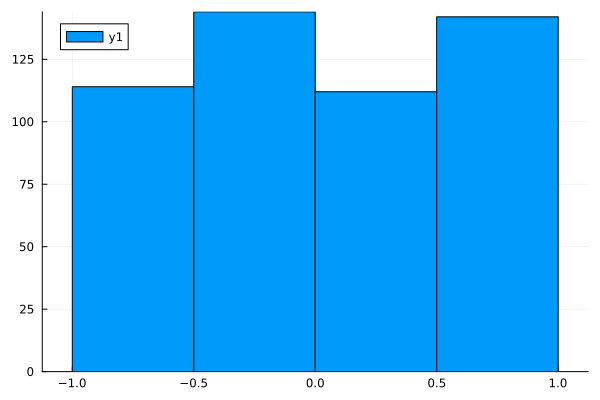

In [20]:
histogram(vec(p_spk[5,:,:]))

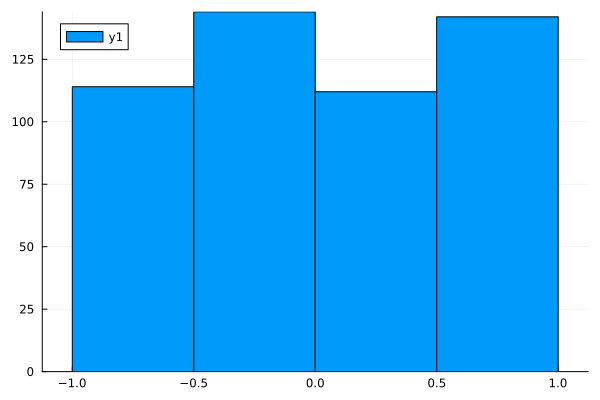

In [21]:
histogram(vec(p_spk[6,:,:]))

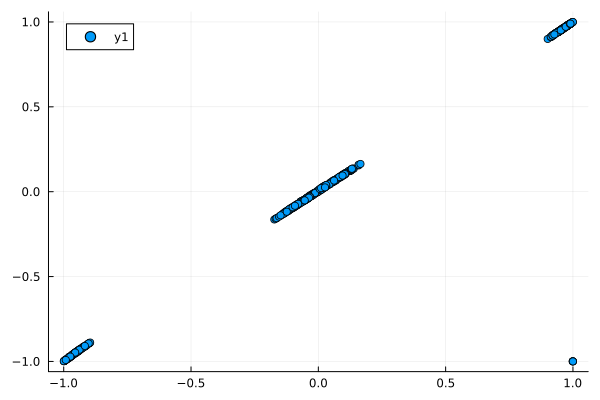

In [22]:
scatter(vec(y), vec(p_spk[5,:,:]))

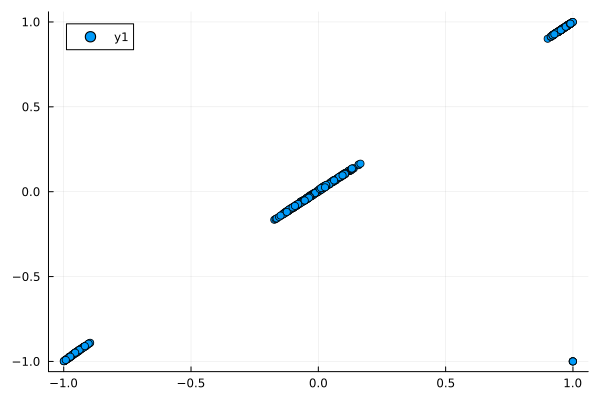

In [23]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [24]:
y |> size

(2, 256)

In [25]:
p_spk |> size

(10, 2, 256)

In [26]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9656482468699713
   0.9660648178402648
   0.9661687143369566
   0.9662140859540418
   0.9662388731949813
   0.9662541613544533
   0.9662643290837604
   0.9662714410207447
   0.7761938302833314

In [27]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.9908472023815197, 1.0630748851172755, 0.9905551344812954, 1.0766145191200653, 0.973124258990807, 1.0032917626575355, 0.966308600061165, 0.978753189293114, 0.9713270872089081, 0.9629775113700485  …  0.07897624643139446, 0.06850759790282211, 0.06231015578052274, 0.06978454383608713, 0.0800947848819977, 0.06824082764413862, 0.07999688900744659, 0.07972453176591007, 0.08496753850678977, 0.07249350958150097], (layer_1 = (bias = Float32[-0.1870782; 0.033379637;;], scale = Float32[0.8734139; 0.86004806;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.028946491 0.005387057; 0.0033044876 -0.09840185; … ; 0.13508473 -0.01793366; -0.23413888 0.011616429], bias_real = Float32[0.9969983, 0.9995214, 1.017481, 0.9951777, 0.9408524, 1.0127898, 0.94907403, 0.96817344, 1.0011506, 0.9349469  …  0.9700956, 0.97604376, 0.99281466, 1.0025088, 0.9959366, 1.0116773, 0.9649697, 0.9857106, 1.0044351, 0.9726991], bias_imag = Float32[-0.0061129835, 0.0025871785, 0.00134638

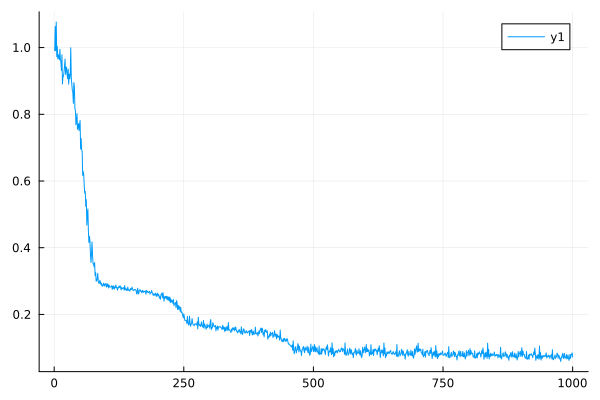

In [28]:
plot(losses)

In [29]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.07638025990993866, 0.968359375)

In [184]:
ps_train.layer_1

(bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;])

In [30]:
yt, _ = model(x, ps_train, st_train)

([-0.10330625845028736 0.20087058626322649 … 0.6290438740086592 0.5139956117946003; 0.37052742705555136 0.27855221613694037 … 0.10673552754915093 -0.02543388159347499], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [31]:
ps_train

(layer_1 = (bias = Float32[-0.1870782; 0.033379637;;], scale = Float32[0.8734139; 0.86004806;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.028946491 0.005387057; 0.0033044876 -0.09840185; … ; 0.13508473 -0.01793366; -0.23413888 0.011616429], bias_real = Float32[0.9969983, 0.9995214, 1.017481, 0.9951777, 0.9408524, 1.0127898, 0.94907403, 0.96817344, 1.0011506, 0.9349469  …  0.9700956, 0.97604376, 0.99281466, 1.0025088, 0.9959366, 1.0116773, 0.9649697, 0.9857106, 1.0044351, 0.9726991], bias_imag = Float32[-0.0061129835, 0.0025871785, 0.0013463844, -0.017203495, 0.06310631, 0.00021533766, -0.04673661, 0.05928495, 0.00046173623, -0.019851472  …  -0.022638872, -0.047216747, -0.014965471, 0.008315789, -0.0012552317, -0.008034801, -0.016628757, 0.016650084, 0.020351322, -0.039371967]), layer_5 = (weight = Float32[0.8991686 -0.8030125 … -0.8121431 -0.8741842; -0.3429668 -0.42367646 … -0.061776515 0.6530509], bias_real = Float32[1.0276608, 0.97301114], bias_

In [32]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [33]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

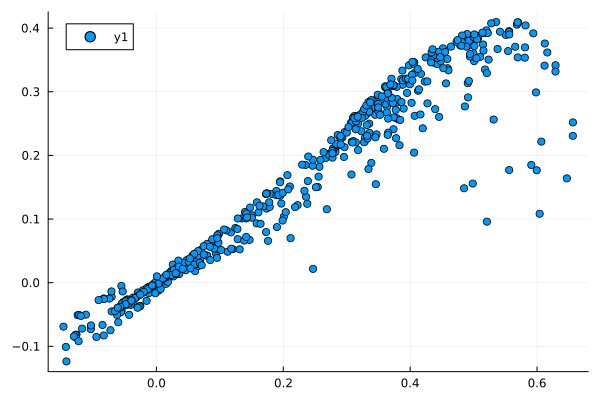

In [34]:
scatter(vec(yt), vec(pt[5,:,:]))

In [35]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 -0.11103476781552735
  0.827396539080224
  0.8915276941579184
  0.9290247526291309
  0.9524922767313215
  0.9678739753760115
  0.978101551124894
  0.9848570289120336
  0.9892731348014119
  0.9908689054892077

# Test FP64

In [36]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03539858 -0.09018608; -0.08312812 -0.037502654; … ; 0.032928616 0.15783635; 0.019997995 -0.14791687], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[0.5699988 -1.0395449 … 0.24616382 -0.26901573; 0.029845295 -0.1120185 … -1.035285 0.3150689], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [37]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.094822 0.07953795; 0.0360204 0.042711686; … ; -0.0078024575 -0.12494607; -0.12408377 0.032318436], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.6479921 0.9973458 … 0.8942231 0.119449; 0.02835401 0.07225186 … -1.620841 0.274164], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [38]:
x

2×256 adjoint(::Matrix{Float64}) with eltype Float64:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [39]:
y, _ = model(x, ps, st)

([0.77231862737836 -0.8509215569831801 … 0.753937553984749 0.9183013227216019; -0.9997130228865855 -0.9939237097824023 … 0.9897709076564167 0.9953183030190571], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [40]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [41]:
y_spk.train.offset

0.5

In [42]:
p_spk = train_to_phase(y_spk);

In [43]:
size(p_spk)

(10, 2, 256)

In [44]:
size(y)

(2, 256)

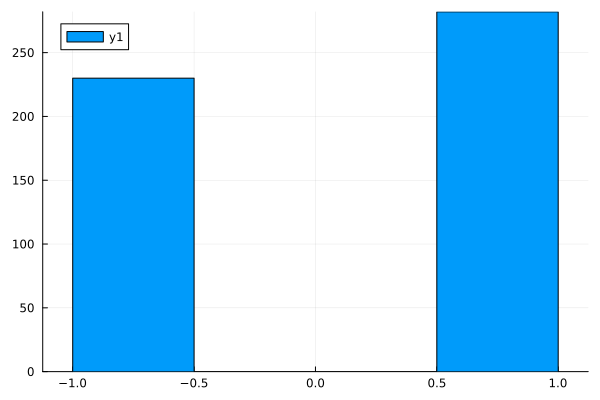

In [45]:
histogram(vec(p_spk[5,:,:]))

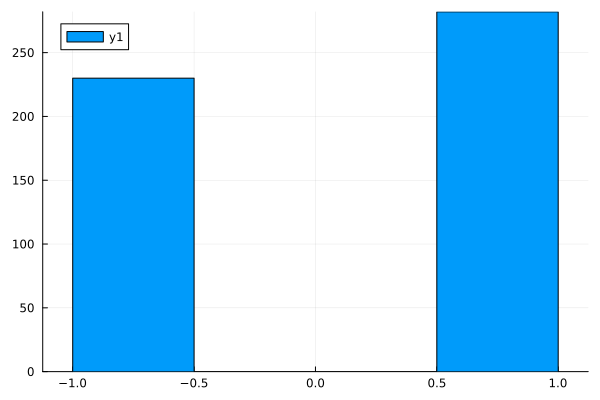

In [46]:
histogram(vec(p_spk[6,:,:]))

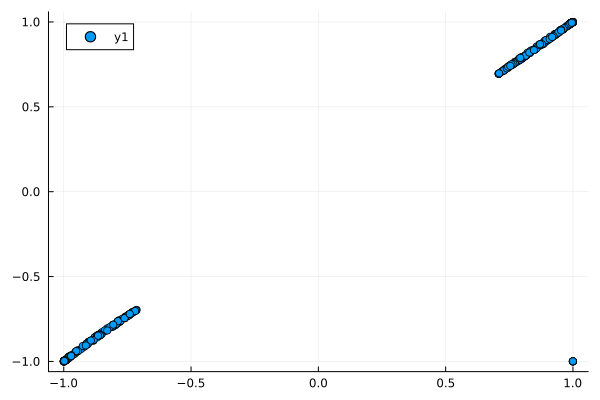

In [47]:
scatter(vec(y), vec(p_spk[5,:,:]))

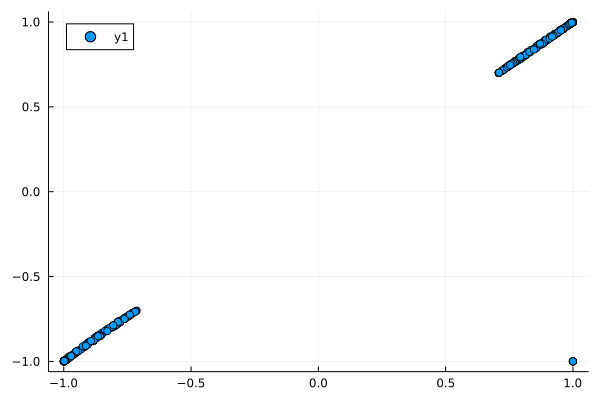

In [48]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [49]:
y |> size

(2, 256)

In [50]:
p_spk |> size

(10, 2, 256)

In [51]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9705371497176739
   0.9723613205098586
   0.9726375001200741
   0.9727375495681877
   0.9727870319081111
   0.9728157517338712
   0.9683826835644542
   0.9683970614437021
   0.475824388581788

In [52]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[1.4389197393261939, 1.5097126463591923, 1.495113041098254, 1.4796776819282231, 1.4722278478760276, 1.4457091550037415, 1.4153194246745533, 1.362738756280335, 1.4558896901772498, 1.3681183489640454  …  0.10052541893727962, 0.10923398356474152, 0.10061819977871889, 0.10079208522465337, 0.10862774145368094, 0.0966093709565636, 0.10580489487782116, 0.09867649882133296, 0.10325721536342838, 0.1053481986101125], (layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.02979184 -0.06757641; -0.10924775 -0.08454099; … ; 0.023975102 0.23201886; -0.02893722 -0.14921162], bias = ComplexF32[1.0007796f0 + 0.013300482f0im, 0.99801666f0 - 0.024188349f0im, 1.0006413f0 - 0.009484197f0im, 1.0003542f0 - 0.006413328f0im, 0.99803704f0 - 0.023194874f0im, 0.9976345f0 + 0.0516281f0im, 0.9992436f0 - 0.012142805f0im, 0.9984052f0 - 0.033760853f0im, 0.99368185f0 - 0.03229597f0im, 1.0010712f0 

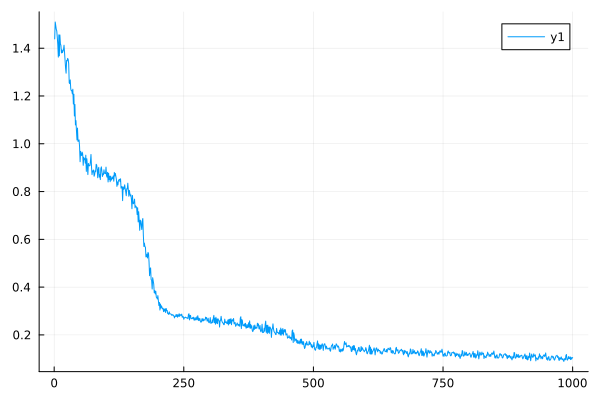

In [53]:
plot(losses)

In [54]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.09899020936212574, 0.952734375)

In [55]:
yt, _ = model(x, ps_train, st_train)

([0.06545331199144964 0.10194505131640488 … 0.4235432780751456 0.3999049097132557; 0.31946540570340853 0.2873106205853458 … 0.18457257696320392 0.06961776683787914], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [56]:
ps_train

(layer_1 = (bias = Float32[0.28128004; -0.06794986;;], scale = Float32[0.80137044; 0.957837;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.02979184 -0.06757641; -0.10924775 -0.08454099; … ; 0.023975102 0.23201886; -0.02893722 -0.14921162], bias = ComplexF32[1.0007796f0 + 0.013300482f0im, 0.99801666f0 - 0.024188349f0im, 1.0006413f0 - 0.009484197f0im, 1.0003542f0 - 0.006413328f0im, 0.99803704f0 - 0.023194874f0im, 0.9976345f0 + 0.0516281f0im, 0.9992436f0 - 0.012142805f0im, 0.9984052f0 - 0.033760853f0im, 0.99368185f0 - 0.03229597f0im, 1.0010712f0 + 0.005167637f0im  …  0.9983705f0 + 0.030321926f0im, 0.9988566f0 + 0.06547444f0im, 0.999413f0 - 0.033684693f0im, 1.0001744f0 + 0.025034197f0im, 0.99681437f0 - 0.0528938f0im, 0.995802f0 - 0.027589887f0im, 0.99914306f0 - 0.015350133f0im, 1.0008062f0 + 0.015466602f0im, 0.99436694f0 - 0.08165437f0im, 0.9989068f0 - 0.058571365f0im]), layer_5 = (weight = Float32[0.5842997 -1.025878 … 0.26487744 -0.25629416; 0.1431507 

In [57]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [58]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

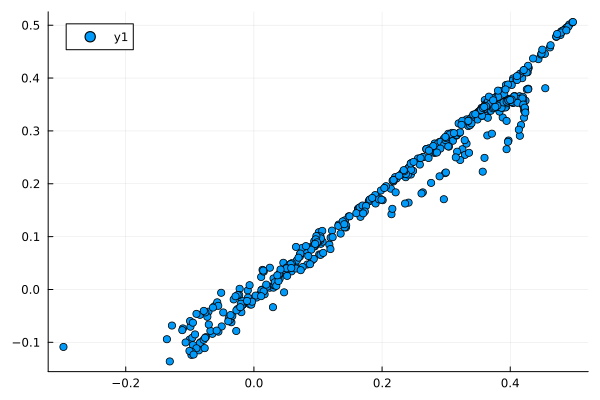

In [59]:
scatter(vec(yt), vec(pt[8,:,:]))

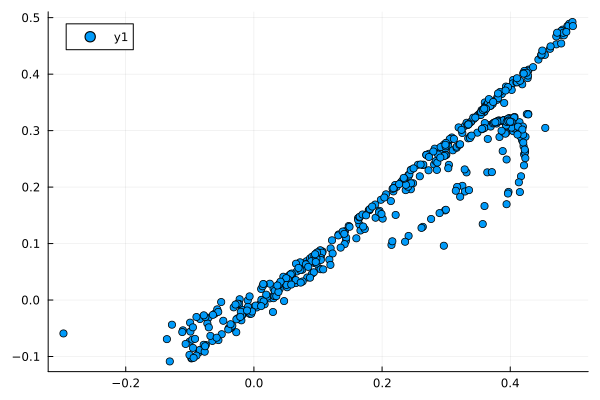

In [60]:
scatter(vec(yt), vec(pt[5,:,:]))

In [61]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 0.07646048395146683
 0.8164369395595024
 0.9038180581225767
 0.943949325415211
 0.9649498052937096
 0.9768660187968112
 0.9839857574401105
 0.9883905729997323
 0.991184612846839
 0.9754595900066031

In [64]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [72]:
p0, _ = to_phase(x, ps_phase, st_phase)

([0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

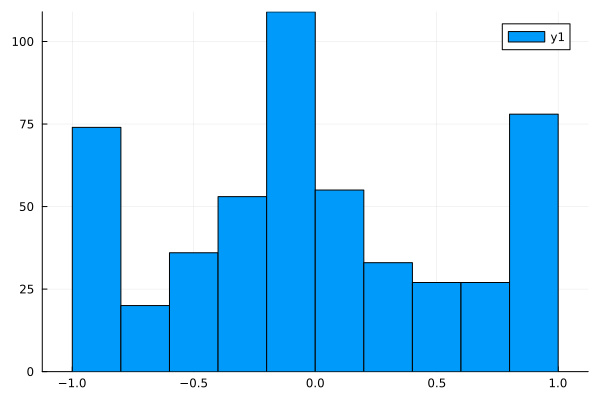

In [74]:
histogram(vec(p0))

In [67]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [69]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [68]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [81]:
using ChainRulesCore: ignore_derivatives

In [120]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, t, spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 2 methods)

In [121]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#115"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

In [122]:
xfn(0.4)

2×256 Matrix{Float64}:
 0.0367008     0.0          5.11018e-138  …  4.11898e-169  0.0           0.0
 3.19094e-194  8.96151e-11  0.0              0.0           1.56768e-302  0.0

In [123]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [166]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#188),
    layer_3 = WrappedFunction(#189),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [167]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.17785951 0.1873955; 0.039497532 0.11593132; … ; -0.0052120984 0.10278214; 0.0042411364 -0.11003012], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [170]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#142"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#115"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof

In [142]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args)[:,:,end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#160),
    layer_3 = WrappedFunction(#161),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction(#162),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [159]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.17465255 0.104539335; -0.16616054 -0.021254854; … ; 0.021506961 0.14189413; 0.20531562 0.19340116], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[-0.8231075 0.20778978 … 0.65797913 0.123956114; 0.12887868 -1.0053909 … 0.1773082 -0.47985777], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [160]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.5058896785114058 0.012790521794627894 … 0.20741247190494552 -0.11452941285349502; -0.6685135121376568 0.5227663941113783 … 0.35358089423846106 -0.9498824498419604], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [161]:
y_ode

2×256 Matrix{Float64}:
 -0.50589   0.0127905  0.549664  …  -0.0838998  0.207412  -0.114529
 -0.668514  0.522766   0.727531      0.989518   0.353581  -0.949882

In [162]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.17465255 0.104539335; -0.16616054 -0.021254854; … ; 0.021506961 0.14189413; 0.20531562 0.19340116], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.8231075 0.20778978 … 0.65797913 0.123956114; 0.12887868 -1.0053909 … 0.1773082 -0.47985777], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [163]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

0.7989501707232566

In [164]:
withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

LoadError: MethodError: no method matching +(::@NamedTuple{u::Nothing, u_analytic::Nothing, errors::Nothing, t::Vector{Float64}, k::Nothing, prob::Nothing, alg::Nothing, interp::Nothing, dense::Nothing, tslocation::Nothing, stats::Nothing, alg_choice::Nothing, retcode::Nothing, resid::Nothing, original::Nothing}, ::ODESolution{ComplexF64, 3, Vector{Matrix{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(weight = ViewAxis(1:256, ShapedAxis((128, 2))), bias = ViewAxis(257:384, ShapedAxis((128, 1))))}}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#142"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#115"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#142"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#115"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Vector{Matrix{ComplexF32}}, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, OrdinaryDiffEq.Tsit5ConstantCache, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing})

[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:587[24m[39m
[0m  +([91m::ChainRulesCore.NotImplemented[39m, ::Any)
[0m[90m   @[39m [32mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/I1EbV/src/[39m[90m[4mtangent_arithmetic.jl:24[24m[39m
[0m  +(::Any, [91m::ChainRulesCore.ZeroTangent[39m)
[0m[90m   @[39m [32mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/I1EbV/src/[39m[90m[4mtangent_arithmetic.jl:100[24m[39m
[0m  ...


In [174]:
solution_to_phase(y_sol, spk_args=spk_args)

128×256×1 Array{Float64, 3}:
[:, :, 1] =
 -0.785483    0.735217     0.839882    …   0.889158    0.466481    0.839953
 -0.603478    0.762767     0.597675        0.86596     0.313481    0.831556
 -0.592409    0.764747     0.589578        0.86428     0.30404     0.830947
 -0.956704    0.705648    -0.793           0.913788    0.624525    0.848892
  0.482418   -0.219442    -0.456363       -0.149201   -0.761616   -0.173957
  0.149403   -0.274605    -0.00572086  …  -0.102637   -0.476358   -0.157076
  0.747896    0.206248    -0.572356       -0.59938     0.961554   -0.613513
 -0.842433    0.726682     0.97431         0.89629     0.516314    0.842535
  0.524343   -0.207585    -0.477499       -0.1594     -0.800279   -0.17769
 -0.242997   -0.730302     0.423674        0.325422   -0.0491981   0.189027
  0.595104   -0.176914    -0.509068    …  -0.1862     -0.869587   -0.187652
  0.546938   -0.199684    -0.488018       -0.166243   -0.82182    -0.18021
  0.926107    0.666847    -0.669926        0.9459

In [177]:
mean(abs.(solution_to_phase(sol_model(x, ps_sol, st_sol)[1], spk_args=spk_args)))

0.5236273295334468

In [180]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.17785951 0.1873955; 0.039497532 0.11593132; … ; -0.0052120984 0.10278214; 0.0042411364 -0.11003012], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))